In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, get_max_distance_to_target_surface, get_average_distance_to_target_surface)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('bob_1', thickness, width, weaving_dir)
# io = InputOrganizer('bunny_quad_1', thickness, thickness, weaving_dir)

#  [ ear 214, ear 255, nose 39]

0.033273539253433904 0.0023291477477403733


In [4]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

### Initialization

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=False,  width_scale = [1, 1.6])
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [33]:
curved_linkage.numJoints()

300

In [34]:
topColor =[79/255., 158/255., 246/255.]
bottomColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [35]:
curved_linkage_view.update(scalarField=colors)

In [36]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [6]:
curved_linkage.attraction_weight = 1e-5

In [7]:
curved_linkage.setExtendedDoFsPSRL(np.load('../../../mega_monster_optimization_diagram_results/bob_1/bob_1_stage_3.npy', allow_pickle = True)[-1]['extendedDoFsPSRL'])
# curved_linkage.setExtendedDoFsPSRL(np.load('results/bob_1/bob_1_dof.npy'))

In [39]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()
curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width * 0.1], stiffAxis=elastic_rods.StiffAxis.D1))
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0)
curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width * 0.5], stiffAxis=elastic_rods.StiffAxis.D1))
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0)
curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0)

In [47]:
feature_joints = [198, 197, 167]

In [40]:
curved_linkage.scaleJointWeights(0.1, 100, feature_joints)
# curved_linkage.scaleJointWeights(0.1, 100, [203, 236, 245, 269, 235, 198, 197, 167, 120, 239])

In [41]:
# jointPos = curved_linkage.jointPositions()
# jointPos = jointPos.reshape((curved_linkage.numJoints(), 3))
# scaled_jointPos = jointPos[np.array([203, 236, 245, 269, 235, 198, 197, 167, 120, 239])]
# with open('{}_feature_joint_pos.obj'.format(io.MODEL_NAME), 'w') as f:
#     for pt in scaled_jointPos:
#         pt *= 100
#         f.write('v {} {} {}\n'.format(pt[0], pt[1], pt[2]))

In [42]:
# curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))

In [8]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [9]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.0177871	5.12781	5.12781	0.5	1
1	0.0124094	29.0769	29.0769	0.0625	1
2	0.00642498	8.26871	8.26871	1	1
3	0.00554995	34.3873	34.3873	0.0625	1
4	0.00504139	22.7537	22.7537	0.125	1
5	0.00489259	9.72442	9.72442	1	1
6	0.00473086	1.8107	1.8107	1	1
7	0.00449233	1.5119	1.5119	1	1
8	0.00409203	1.32248	1.32248	1	1
9	0.00348156	1.10643	1.10643	1	1
10	0.00268949	0.854168	0.854168	1	1
11	0.00186225	0.605613	0.605613	1	1
12	0.00119211	0.407535	0.407535	1	1
13	0.000768853	0.266514	0.266514	1	1
14	0.000544846	0.16572	0.16572	1	1
15	0.000427481	0.0985162	0.0985162	1	1
16	0.000352837	0.0588898	0.0588898	1	1
17	0.000293562	0.0363408	0.0363408	1	1
18	0.000241212	0.0223402	0.0223402	1	1
19	0.000194342	0.0132992	0.0132992	1	1
20	0.00015343	0.00783953	0.00783953	1	1
21	0.000118983	0.00590719	0.00590719	1	1
22	9.18683e-05	0.00771418	0.00771418	1	1
23	7.30938e-05	0.0109143	0.0109143	1	1
24	6.20012e-05	0.0101785	0.0101785	1	1
25	5.62534e-05	0.00812458	0.00812458	1	1
26	5.3504e-05	0.00644651	0.00644651	1	1
27	5

In [45]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [48]:
optimizer.scaleJointWeights(0.01, 100, feature_joints)

In [49]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

rl_regularization_weight 1.0
smoothing_weight 10.0
stage 2 optimization with attraction weight 100.0
stage 2 optimization with attraction weight 0.03162277660168379
stage 2 optimization with attraction weight 1e-05


### Validation

In [15]:
# curved_optimizer_energy = curved_linkage.energy()
# validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
# validation_curved_linkage.attraction_weight = 1e-7
# with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
# validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
# validation_curved_energy = validation_curved_linkage.energy()
# print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [16]:
# validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(validation_curved_view)
# validation_curved_view.show()

In [25]:
double_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH, width=1024, height=640)
set_surface_view_options(double_view)
double_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [ ]:
double_view.viewOptions[double_view.ViewType.SURFACE].color

In [17]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(curved_linkage)

In [37]:
get_average_distance_to_target_surface(curved_linkage)/io.RIBBON_CS[1]

0.2632755266184439

In [44]:
distance_to_surface = np.array(curved_linkage.get_squared_distance_to_target_surface((curved_linkage.visualizationGeometry()[0]).flatten()))


In [45]:
distance_to_surface = np.sqrt(distance_to_surface)

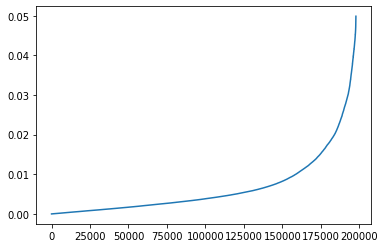

In [54]:
plt.plot(np.sort(distance_to_surface))


In [21]:
set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [43]:
200.35940919566144 * io.RIBBON_CS[1]

5.0

Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 308
num seg per rod 50
num seg per rod 176
num seg per rod 42
num seg per rod 24
30.053911379349216


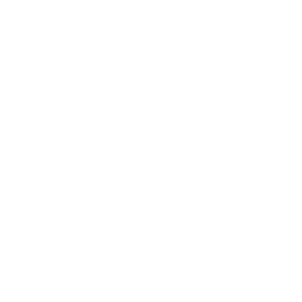

In [21]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_no_feature_joints', io.RIBBON_NAME + '_no_feature_joints', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)

In [40]:
curved_linkage.numSegments()

618

## Contact Optimization

In [25]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [26]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/bunny_head_small_triaxial_1/bunny_head_small_triaxial_1_dof.npy'))

In [27]:
curved_linkage.attraction_weight = 1e-5

In [28]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [29]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

0	0.00432216	1.14356	1.14356	1	1
1	0.000570708	0.315069	0.315069	1	1
2	0.000379947	0.0816982	0.0816982	1	1
3	0.000279816	0.0368005	0.0368005	1	1
4	0.00020388	0.0209519	0.0209519	1	1
5	0.000142562	0.0117231	0.0117231	1	1
6	9.67677e-05	0.006184	0.006184	1	1
7	6.48816e-05	0.00329029	0.00329029	1	1
8	4.44935e-05	0.00194211	0.00194211	1	1
9	3.31504e-05	0.00140224	0.00140224	1	1
10	2.78864e-05	0.00124206	0.00124206	1	1
11	2.58379e-05	0.00103332	0.00103332	1	1
12	2.51131e-05	0.000693905	0.000693905	1	1
13	2.48546e-05	0.000385459	0.000385459	1	1
14	2.47536e-05	0.000184354	0.000184354	1	1
15	2.46983e-05	8.25414e-05	8.25414e-05	1	1
16	2.46437e-05	3.54887e-05	3.54887e-05	1	1
17	2.45676e-05	2.43904e-05	2.43904e-05	1	1
18	2.44542e-05	3.54731e-05	3.54731e-05	1	1
19	2.42886e-05	5.92253e-05	5.92253e-05	1	1
20	2.40572e-05	0.000108214	0.000108214	1	1
21	2.37611e-05	0.000218146	0.000218146	0.25	0
22	2.33676e-05	0.00169085	0.00169085	1	0
23	2.2928e-05	0.00164434	0.00164434	1	0
24	2.26256e-05	0.00183251	0.

In [31]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = [])

In [32]:
optimizer.setLinkageAttractionWeight(1e-5)

Coefficient of Friction Percentiles 50, 75, 90:  0.5456741448174469 0.9823617529257985 2.4043848727420807


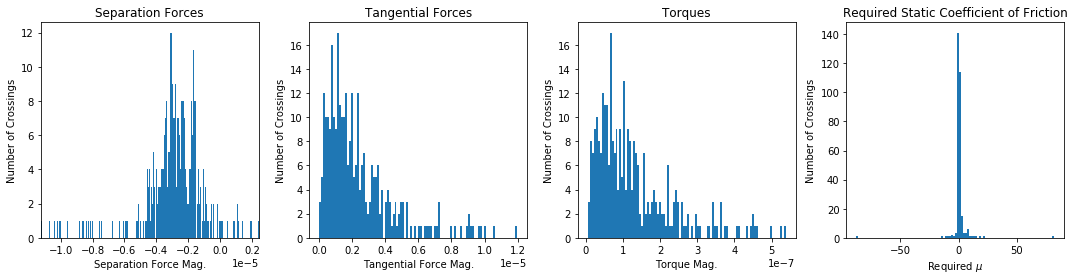

In [10]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [ ]:
contact_optimization(optimizer, curved_linkage_view, -1, 1e4)

In [ ]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()